In [1]:
import os
import sys
import pydub
import librosa
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# obtain two audio files for comparison
arun = '/home/cc/Audio/Train/arun_alphabet.wav'
andrew = '/home/cc/Audio/Train/andrew_alphabet.wav'
arun_pydub = pydub.AudioSegment.from_wav(arun)
andrew_pydub = pydub.AudioSegment.from_wav(andrew)
y_arun, sr_arun = librosa.load(arun)
y_andrew, sr_andrew = librosa.load(andrew)

In [22]:
# create overlay data, save it to file and then load in librosa
overlay = arun_pydub.overlay(andrew_pydub)
overlay.export('overlay.wav', format='wav')
y_overlay, sr_overlay = librosa.load('overlay.wav')

In [23]:
S_arun = np.abs(librosa.stft(y_arun))
S_andrew = np.abs(librosa.stft(y_andrew))
S_overlay = np.abs(librosa.stft(y_overlay))

In [29]:
comps, acts = librosa.decompose.decompose(S_overlay, n_components=4)

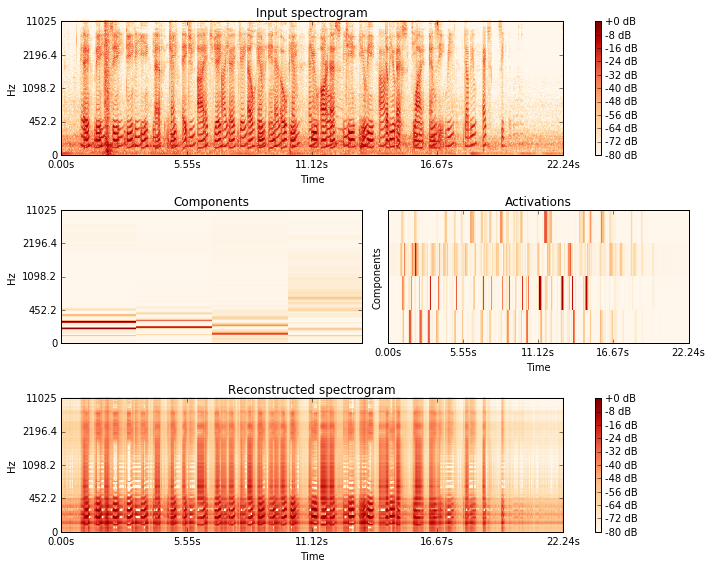

In [30]:
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.logamplitude(S_overlay**2,ref_power=np.max),y_axis='log', x_axis='time')
plt.title('Input spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.subplot(3, 2, 3)
librosa.display.specshow(comps, y_axis='log')
plt.title('Components')
plt.subplot(3, 2, 4)
librosa.display.specshow(acts, x_axis='time')
plt.ylabel('Components')
plt.title('Activations')
plt.subplot(3, 1, 3)
S_approx = comps.dot(acts)
librosa.display.specshow(librosa.logamplitude(S_approx**2,ref_power=np.max),y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed spectrogram')
plt.tight_layout()
plt.show()

In [35]:
print(comps.shape, acts.shape)

((1025, 4), (4, 959))


In [4]:
# compute ICA
Y = np.asarray(y_overlay)
#ica = FastICA(n_components=2)
#S = ica.fit_transform(Y)

In [5]:
ica = FastICA(n_components=2)

In [34]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal
print(s1.shape, s2.shape, s3.shape)
S = np.c_[s1, s2, s3]
print(S.shape)
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
print(S.shape)
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
print(A.shape)
X = np.dot(S, A.T)  # Generate observations
print(X.shape)
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

((2000,), (2000,), (2000,))
(2000, 3)
(2000, 3)
(3, 3)
(2000, 3)


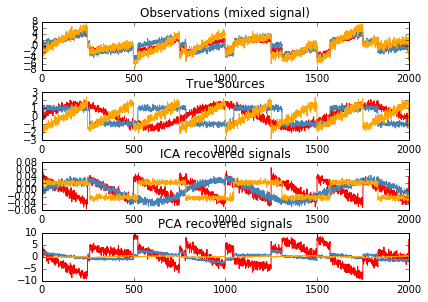

In [29]:
plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

In [31]:
nick = np.array([1,2,3,4])

In [6]:
combo = np.c_[y_overlay]

In [7]:
print(y_overlay.shape, combo.shape)

((490568,), (490568, 1))


In [8]:
ica = FastICA(n_components=2)
combo_ica = ica.fit_transform(combo)

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:296: UserWarning: n_components is too large: it will be set to 1
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


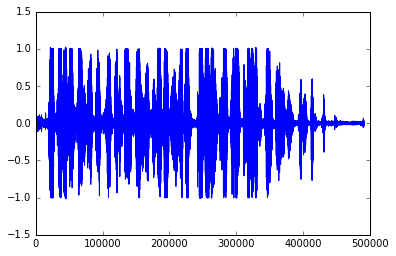

In [9]:
models = [combo, combo_ica]
plt.plot(combo)
plt.show()

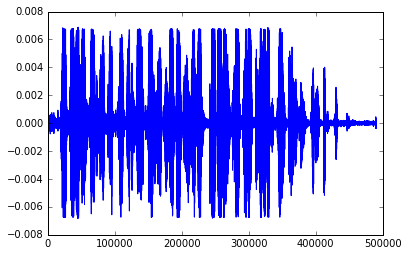

In [10]:
plt.plot(combo_ica)
plt.show()

[[  3.38659622e-03]
 [  5.78273274e-03]
 [  6.31315354e-03]
 ..., 
 [  8.03221701e-05]
 [ -5.89891642e-05]
 [  4.17874508e-05]]
1
[  3.38659622e-03   5.78273274e-03   6.31315354e-03 ...,   8.03221701e-05
  -5.89891642e-05   4.17874508e-05]
red
[[  2.39774077e-05]
 [  4.00847814e-05]
 [  4.36503907e-05]
 ..., 
 [  1.75188026e-06]
 [  8.15397703e-07]
 [  1.49284108e-06]]
2
[  2.39774077e-05   4.00847814e-05   4.36503907e-05 ...,   1.75188026e-06
   8.15397703e-07   1.49284108e-06]
red


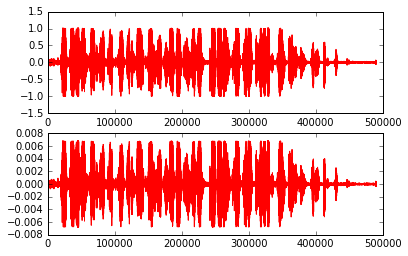

In [21]:
colors = ['red', 'steelblue']
for ii, model in enumerate(models, 1):
    plt.subplot(2, 1, ii)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

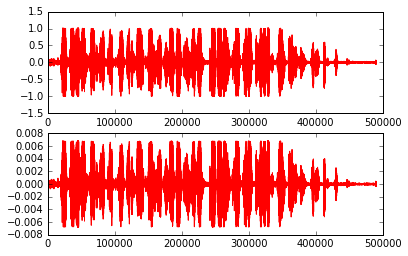

In [16]:
plt.show()